In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import random
import joblib

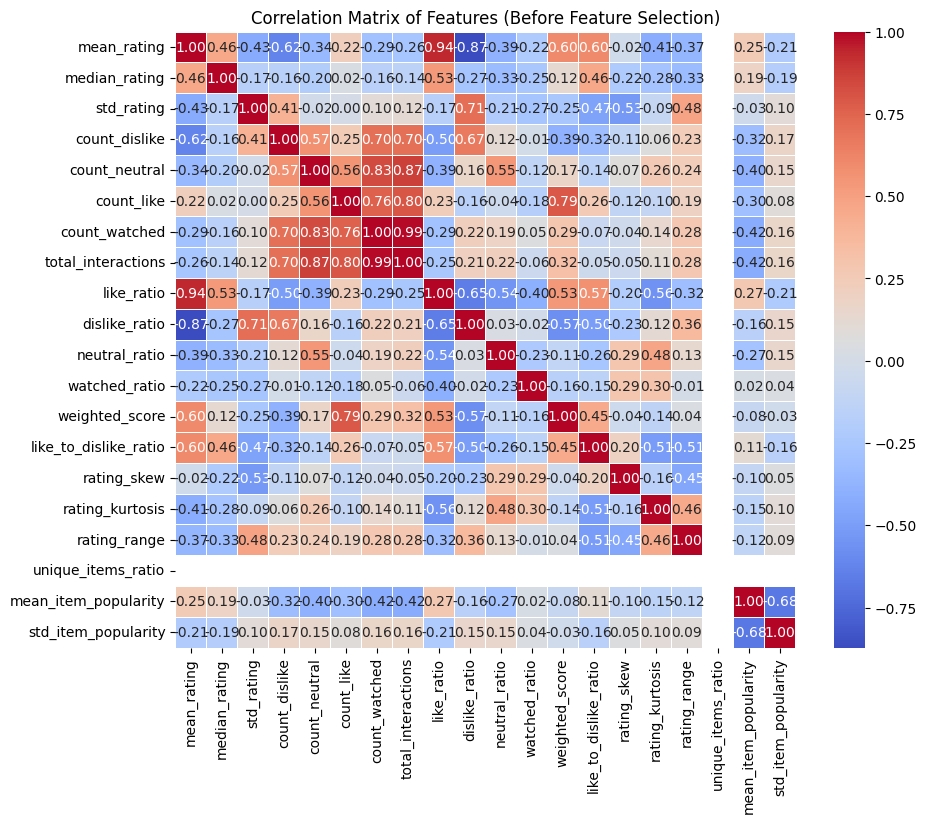

Mutual Information Scores:
watched_ratio            0.190493
mean_rating              0.085785
like_ratio               0.085064
like_to_dislike_ratio    0.076324
weighted_score           0.073927
dislike_ratio            0.063486
neutral_ratio            0.052185
rating_kurtosis          0.050252
std_rating               0.048566
rating_skew              0.040951
count_dislike            0.037040
median_rating            0.022552
count_like               0.022292
count_neutral            0.019633
count_watched            0.013554
mean_item_popularity     0.006267
total_interactions       0.004466
rating_range             0.001633
unique_items_ratio       0.000000
std_item_popularity      0.000000
Name: MI Scores, dtype: float64


In [18]:
# Load the dataset
data = np.load("first_batch_multi_labels.npz")
X = data["X"]
y = data["yy"]

# Create DataFrames
df_X = pd.DataFrame(X, columns=["user", "item", "rating"])
df_y = pd.DataFrame(y, columns=["user", "label"])

def engineer_features(df_X, top_features=None, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby('user').agg(
        mean_rating=('rating', 'mean'),
        median_rating=('rating', 'median'),
        std_rating=('rating', 'std'),
        count_dislike=('rating', lambda x: (x == -10).sum()),
        count_neutral=('rating', lambda x: (x == 0).sum()),
        count_like=('rating', lambda x: (x == 10).sum()),
        count_watched=('rating', lambda x: (x == 1).sum()),
        total_interactions=('rating', 'count')
    )

    # Ratio features
    df_user_features['like_ratio'] = df_user_features['count_like'] / df_user_features['total_interactions']
    df_user_features['dislike_ratio'] = df_user_features['count_dislike'] / df_user_features['total_interactions']
    df_user_features['neutral_ratio'] = df_user_features['count_neutral'] / df_user_features['total_interactions']
    df_user_features['watched_ratio'] = df_user_features['count_watched'] / df_user_features['total_interactions']

    # Weighted scores
    df_user_features['weighted_score'] = df_user_features['count_like'] * 1.5 - df_user_features['count_dislike'] * 1.5
    
    # Interaction patterns
    df_user_features['like_to_dislike_ratio'] = df_user_features['count_like'] / (df_user_features['count_dislike'] + 1)

    # Distribution features
    df_user_features['rating_skew'] = df_X.groupby('user')['rating'].apply(lambda x: skew(x))
    df_user_features['rating_kurtosis'] = df_X.groupby('user')['rating'].apply(lambda x: kurtosis(x))
    
    # User behavior patterns
    df_user_features['rating_range'] = df_X.groupby('user')['rating'].apply(lambda x: x.max() - x.min())
    df_user_features['unique_items_ratio'] = df_X.groupby('user')['item'].nunique() / df_user_features['total_interactions']
    
    # Item popularity metrics
    item_popularity = df_X.groupby('item')['rating'].agg(['mean', 'count'])
    item_popularity['popularity_score'] = item_popularity['mean'] * np.log1p(item_popularity['count'])
    
    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(df_X, item_popularity['popularity_score'], left_on='item', right_index=True)
    
    # User-item interaction features
    df_user_features['mean_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].mean()
    df_user_features['std_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].std()

    # If labels are provided, merge with df_y
    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on='user')

        # Calculate and display correlation matrix before mutual information is removed
        correlation_matrix = df_merged.drop(columns=['user', 'label']).corr()

        # Set up the matplotlib figure and draw the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Matrix of Features (Before Feature Selection)')
        plt.show()

        # Feature selection using mutual information
        X = df_merged.drop(columns=['user', 'label'])
        y = df_merged['label']
        mi_scores = mutual_info_classif(X, y)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)

        print("Mutual Information Scores:")
        print(mi_scores)
        
        # Select top 10 features
        top_features = mi_scores.nlargest(10).index.tolist()

        # Return the merged dataframe with selected features, label, and top features
        return df_merged[['user'] + top_features + ['label']], top_features

    # If no labels (unseen data), just select the top features
    else:
        # Ensure top_features is provided
        if top_features is None:
            raise ValueError("top_features must be provided for unseen data")
        
        # Return the dataframe with only the selected top features
        df_merged = df_user_features.reset_index()
        return df_merged[['user'] + top_features]

# Use the function
df_merged, top_features = engineer_features(df_X, df_y=df_y)

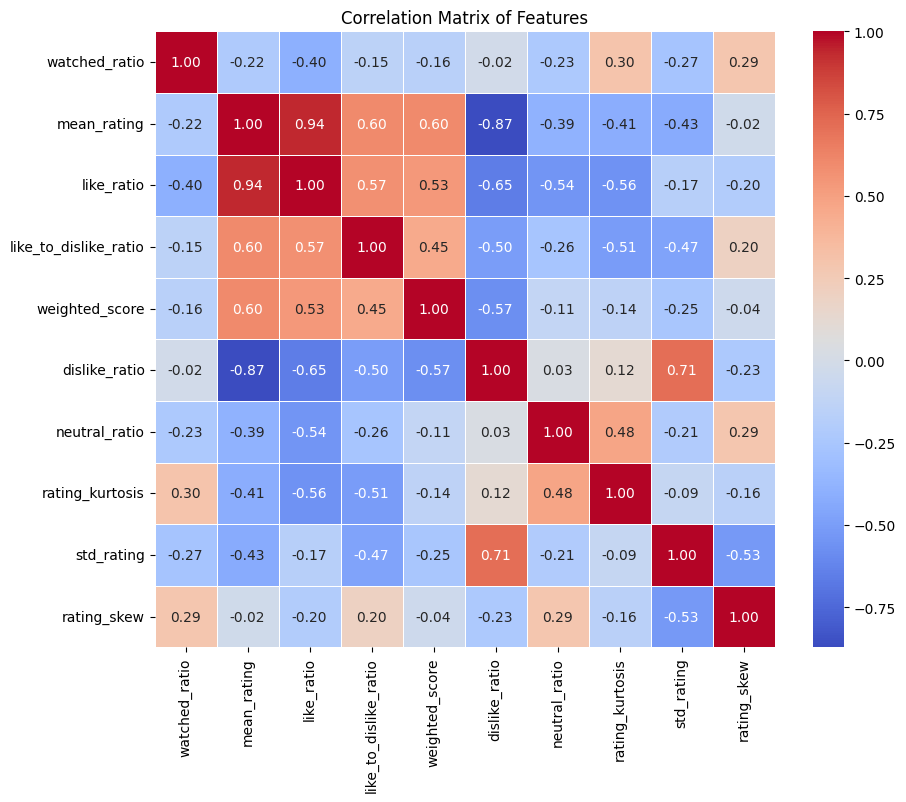

In [19]:
# Compute correlation matrix
correlation_matrix = df_merged.drop(columns=['user', 'label']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix of Features')
plt.show()

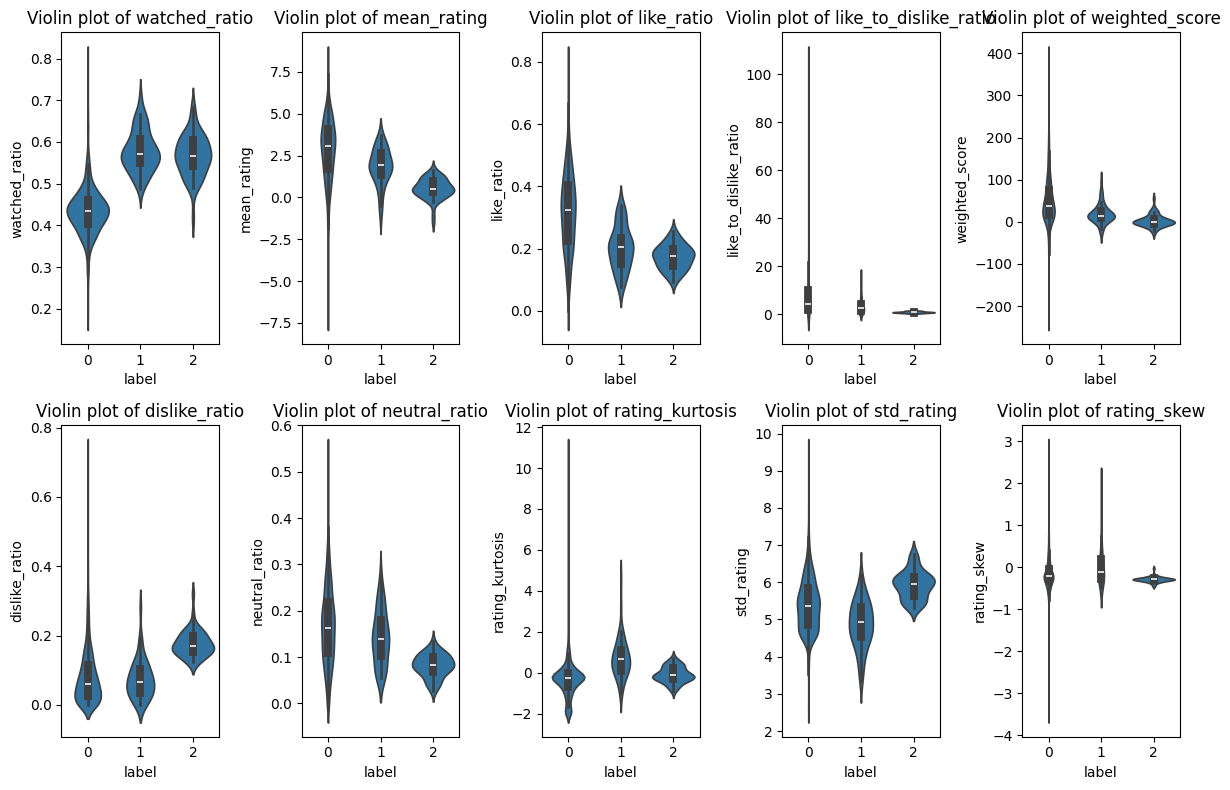

In [20]:
def plot_violin_for_top_features(df_merged, top_features):
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Loop through each top feature and create a violin plot
    for i, feature in enumerate(top_features):
        plt.subplot(2, 5, i + 1)  # Adjust the subplot grid based on the number of top features
        sns.violinplot(x='label', y=feature, data=df_merged)
        plt.title(f"Violin plot of {feature}")
        plt.tight_layout()

    # Display the plot
    plt.show()

# Call the plotting function with the merged dataframe and top features
plot_violin_for_top_features(df_merged, top_features)